<p style="font-size:30px; font-weight:bold; text-align:center;">Detektor Fake Newsów</p>
<p style="font-size:20px;  text-align:center;">Marcel Gołąb 285300</p>
<p style="font-size:15px; text-align:center;">W oparciu o: <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9395133" target="_blank">WELFake: Word Embedding Over Linguistic Features for Fake News Detection</a></p>


# 1. Przygotowanie środowiska 🌍🔧

## Wczytanie bibliotek 📚

In [1]:
import torch
import torch.nn as nn
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import re
from collections import defaultdict, Counter
import spacy
import pickle
from torch.nn.utils.rnn import pad_sequence
import time
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

/home/marcgol/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CUDA/CPU ⚡💻

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Ziarenko 🌱

In [3]:
seed = 12
torch.manual_seed(seed)  # Ustawienie ziarna dla CPU
np.random.seed(seed)  # Ustawienie ziarna dla NumPy
random.seed(seed)  # Ustawienie ziarna dla standardowej biblioteki Pythona
torch.backends.cudnn.deterministic = True  # Zapewnienie deterministycznych wyników w CUDA
torch.backends.cudnn.benchmark = False  # Wyłączenie optymalizacji dla deterministycznych wyników

# 2. Zbiór danych 🗃️📑

**Word Embedding over Linguistic Features for Fake News Detection**

**Wektorowe reprezentacje słów oparte na cechach językowych do wykrywania fałszywych wiadomości**

Zestaw danych jest połączniem czterech zbiorów danych newsowych z platform:
- Kaggle,
- McIntire,
- Reuters,
- BuzzFeed Political.

Cały zbiór zawiera **72 134** artykułów prasowych. Artykuły pochodzą głównie z lat 2016-2020 i obejmują one tematykę polityczną i społeczną.

Kolumny:
- Numer seryjny / id
- Tytuł
- Tekst
- Etykieta (0 = prawdziwy, 1 = fake)

<a href="https://zenodo.org/records/4561253" target="_blank">Źródło</a>

## Pobranie danych ⬇️💾

In [4]:
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")
print("Path to dataset files:", path)

Path to dataset files: /home/marcgol/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77


## Załadowanie danych 📥

In [5]:
search_directory = "/home/marcgol/"
for root, dirs, files in os.walk(search_directory):
    for file in files:
        if file == "WELFake_Dataset.csv":
            file_path = os.path.join(root, file)
            print(f"Plik znaleziony: {os.path.join(root, file)}")

Plik znaleziony: /home/marcgol/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77/WELFake_Dataset.csv


In [6]:
d = pd.read_csv(file_path)
d

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


## Operacje na danych 🔄🛠️
- Usunięcie pierwszek kolumny
- Usunięcie pustych wartości (znikoma ilość w porównaniu do całego zbioru ~0.83%)
- Usunięcie duplikatów
- Złączenie tytułów z tekstami
- Zamiana dużych liter na małe (jeśli cały wyraz nie jest zapisany w całości z dużych liter)

In [7]:
d = d.iloc[:, 1:]

In [8]:
d.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [9]:
d.dropna(inplace=True)

In [10]:
d.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [11]:
d.duplicated().sum()

8416

In [12]:
d = d.drop_duplicates()
d.duplicated().sum()

0

### Realna liczba danych

In [13]:
print('Liczba danych:', d.shape[0])

Liczba danych: 63121


In [14]:
d['combined_text'] = d['title'] + " " + d['text']

In [15]:
def conditional_lowercase(text):
    """
    Zamienia na małe litery tylko te wyrazy, które nie są w całości wielkimi literami.

    Args:
    text (str): Tekst do przetworzenia.

    Returns:
    str: Zaktualizowany tekst.
    """
    words = text.split()
    processed_words = [word.lower() if not word.isupper() else word for word in words]
    return " ".join(processed_words)

d['combined_text'] = d['combined_text'].apply(conditional_lowercase)

In [16]:
d

,title,text,label,combined_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT following threat...
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"bobby jindal, raised hindu, uses story of chri..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: russia unvelis an image of its terrif...
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,about time! christian group sues amazon and SP...
...,...,...,...,...
72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,russians steal research on trump in hack of U....
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,WATCH: giuliani demands that democrats apologi...
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,migrants refuse to leave train at refugee camp...


## Wizualizacja danych 📊

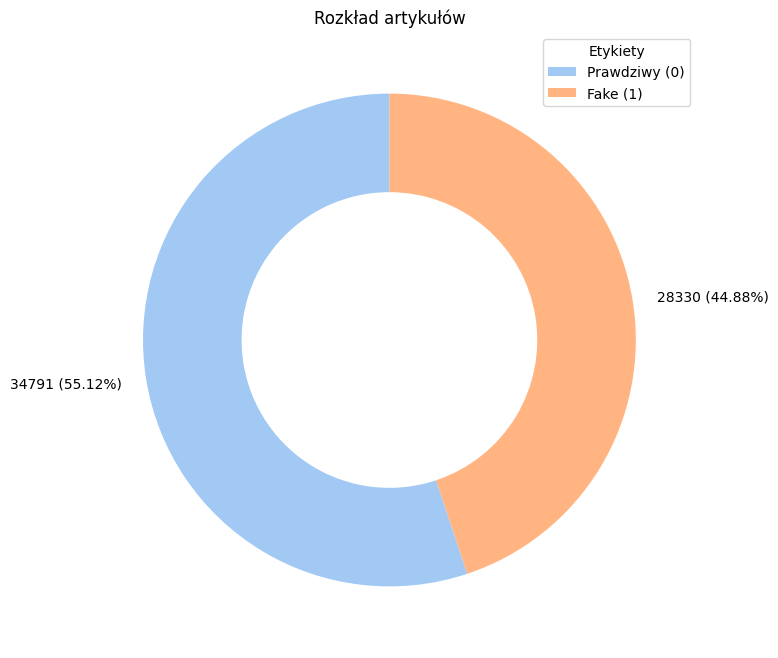

In [17]:
label_counts = d['label'].value_counts()
labels = ['Prawdziwy (0)', 'Fake (1)']

values = label_counts.values
percentages = [f"{value} ({value / sum(values) * 100:.2f}%)" for value in values]

colors = sns.color_palette("pastel", len(values))

plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(
    values, labels=percentages, startangle=90,
    colors=colors, wedgeprops=dict(width=0.4)
)

plt.legend(wedges, labels, title="Etykiety", loc=1)
plt.title("Rozkład artykułów")
plt.show()

<div class="alert alert-block alert-info">  
<b>Wniosek:</b> Klasy są zbalansowane
</div>

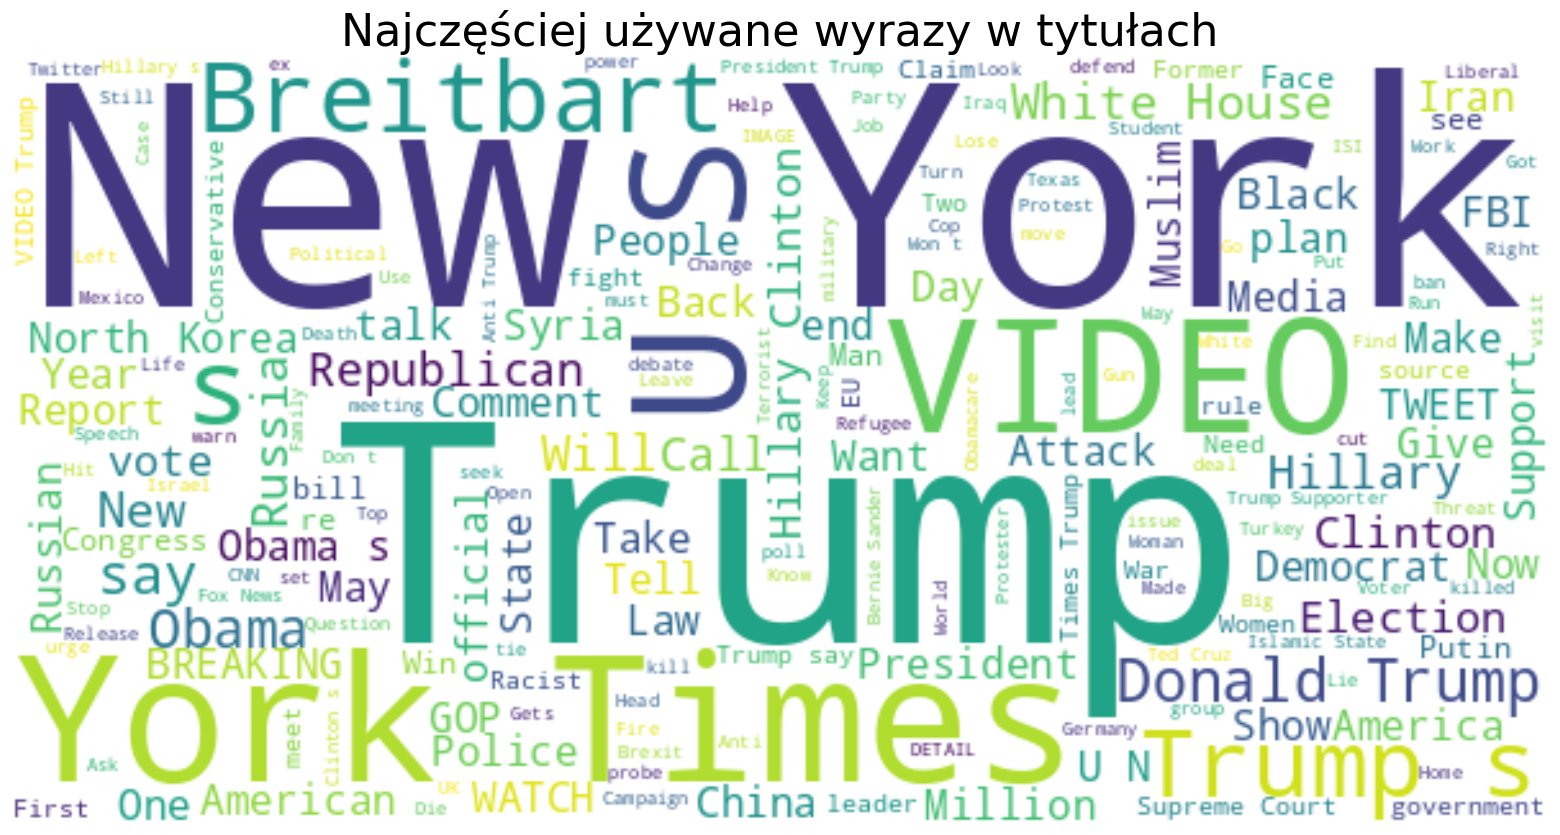

In [18]:
titles = ' '.join(title for title in d['title'])
wordcloud = WordCloud(
    background_color='white', 
    max_words=200,
    width=600, 
    height=300,
).generate(titles)

plt.figure(figsize=(20, 10))
plt.title("Najczęściej używane wyrazy w tytułach", fontsize=32)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

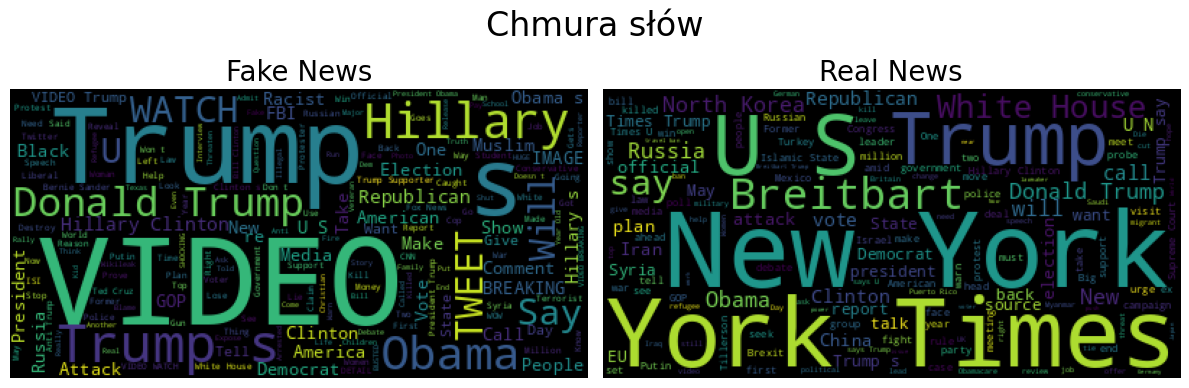

In [19]:
text_fake = ' '.join(d.loc[d['label'] == 1]['title'])
text_real = ' '.join(d.loc[d['label'] == 0]['title'])

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,8))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Fake News",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Real News",fontsize=20)

plt.suptitle("Chmura słów", y=0.7, fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

Widać wyraźne różnice w słownictwie między tytułami fake newsów a prawdziwych artykułów:
- W tytułach fake newsów wyraz *video* jest częsty, co może wskazywać na próbę zwiększenia atrakcyjności treści i wzbudzenia ciekawości czytelnika.
- Tytuły prawdziwych artykułów często zawierają nazwy znanych mediów, takich jak *The New York Times* czy *Breitbart*, co dodaje im autorytetu.
- W obu typach artykułów często pojawia się nazwisko Donalda Trumpa, wskazując na dominację tematów politycznych w zbiorze.

Ogólnie baza danych skupia się na polityce i wydarzeniach społecznych, co jest widoczne w analizie słów kluczowych.

Chcąc potwierdzić punkt nr. 2, spójrzmy na wykres wiarygodności mediów. Widać na nim, że informacje opublikowane przez NYT oraz Breibart w większości są uznawane za prawdziwe.

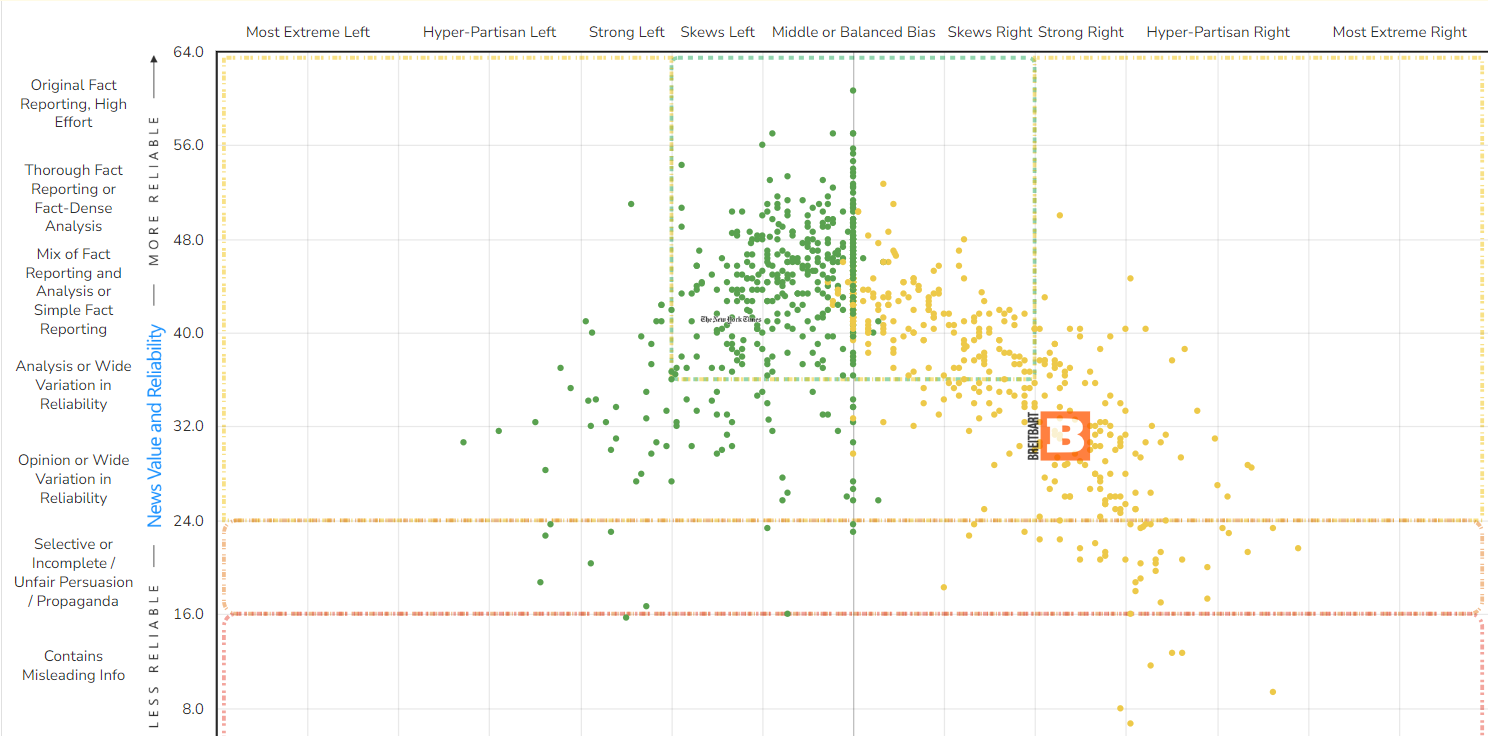

<a href="https://app.adfontesmedia.com/chart/interactive" target="_blank">Źródło</a>

In [20]:
# Tworzenie słowników do zliczania słów dla każdego labela i znaku
label_word_count = defaultdict(lambda: defaultdict(int))
sample_words = defaultdict(lambda: defaultdict(list))

labels = ['0', '1']
characters = ['*', '#', '%', '$', '@', '&', '/']

for index, row in d.iterrows():
    text = row['combined_text']
    label = row['label']
    
    special_words = re.findall(r'\b\w*[#*%$@^&/]\w*\b', text)
    
    for word in special_words:
        for char in characters:
            if char in word:
                label_word_count[label][char] += 1
                sample_words[label][char].append(word)

for char in characters:
    print(f"\nPrzykłady słów zawierających '{char}':")
    for label in [0, 1]:
        word_counts = Counter(sample_words[label][char])
        most_common_words = word_counts.most_common(5)
        
        print(f"Label {label}: {', '.join([word for word, _ in most_common_words])}")


Przykłady słów zawierających '*':
Label 0: f*ck, f*cking, sh*t, b*tch, f*cked
Label 1: f*ck, sh*t, f*cking, bullsh*t, p*ssy

Przykłady słów zawierających '#':
Label 0: 0x10012aa4#wannacryptattribution, election#nrwltw17, foreverychild#parisagreement, عملية_القدس#انتفاضة_القدس, قدرتك#انتفاضة_القدس
Label 1: js#xfbml, 2016#whywomendontreport, 2017#trump, 2017#trumpchicken, #maga

Przykłady słów zawierających '%':
Label 0: here%20notification, 20steven%20t
Label 1: %22, %2c, %3a, %5b, %5d

Przykłady słów zawierających '$':
Label 0: A$250, C$1, C$10, A$200, S$10
Label 1: fvnk$oul, 0$0, _$_, funk$oul, us$20k

Przykłady słów zawierających '@':
Label 0: briefing@nytimes, igcolonel@hotmail, awrhawkins@breitbart, bkew@breitbart, lnolan@breitbart
Label 1: 2017@realdonaldtrump, 2016@realdonaldtrump, 2017@ivankatrump, 2016@sarahpalinusa, 2017@sarahpalinusa

Przykłady słów zawierających '&':
Label 0: S&P, AT&T, Q&A, BB&T, at&t
Label 1: AT&T, tzrwu&utm_campaign, placement&utm_source, com&utm_medium,

<div class="alert alert-block alert-danger">  
<b>Fake News:</b> Zawierają hasztagi służące propagandzie i manipulacji oraz odnośniki do tweetów.
</div>

<div class="alert alert-block alert-success">  
<b>Real News:</b> Zawierają hasztagi odnoszące się np. do paryskiego porozumienia klimatycznego i oprogramowania szantażującego WannaCry.
Dodatkowo @ odnosi się do adresów mailowych.
</div>

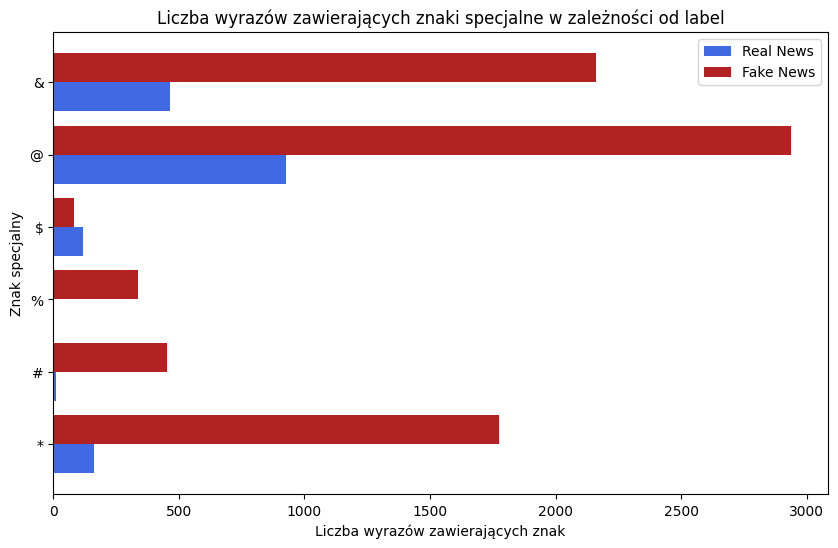

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.4
characters_subset = characters[:6]

for i, char in enumerate(characters_subset):
    count_0 = label_word_count[0].get(char, 0)
    count_1 = label_word_count[1].get(char, 0)
    
    ax.barh(i - bar_width / 2, count_0, bar_width, color='royalblue', label='Real News' if i == 0 else "")
    ax.barh(i + bar_width / 2, count_1, bar_width, color='firebrick', label='Fake News' if i == 0 else "")

ax.set_yticks(range(len(characters_subset)))
ax.set_yticklabels(characters_subset)

ax.set_xlabel('Liczba wyrazów zawierających znak')
ax.set_ylabel('Znak specjalny')
ax.set_title('Liczba wyrazów zawierających znaki specjalne w zależności od label')

ax.legend()
plt.show()

<div class="alert alert-block alert-danger">  
<b>Fake News:</b> Tendencja do użycia znaków specjalnych.
</div>

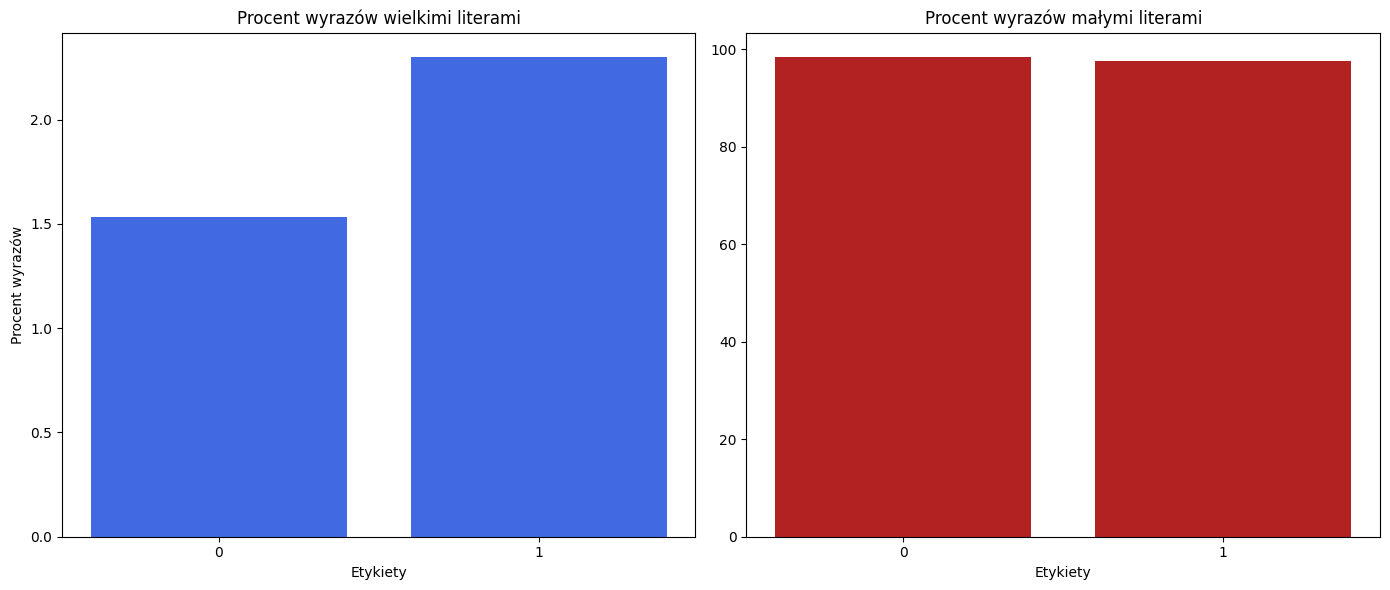

In [22]:
def count_upper_lower(text):
    words = text.split()
    upper_count = sum(1 for word in words if word.isupper())
    lower_count = sum(1 for word in words if not word.isupper())
    return upper_count, lower_count

label_counts = {0: {'upper': 0, 'lower': 0}, 1: {'upper': 0, 'lower': 0}}

for _, row in d.iterrows():
    upper, lower = count_upper_lower(row['combined_text'])
    label_counts[row['label']]['upper'] += upper
    label_counts[row['label']]['lower'] += lower

total_counts = {label: sum(values.values()) for label, values in label_counts.items()}
upper_percents = [label_counts[0]['upper'] / total_counts[0] * 100, label_counts[1]['upper'] / total_counts[1] * 100]
lower_percents = [label_counts[0]['lower'] / total_counts[0] * 100, label_counts[1]['lower'] / total_counts[1] * 100]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

ax1.bar(labels, upper_percents, color='royalblue')
ax1.set_title('Procent wyrazów wielkimi literami')
ax1.set_xlabel('Etykiety')
ax1.set_ylabel('Procent wyrazów')

ax2.bar(labels, lower_percents, color='firebrick')
ax2.set_title('Procent wyrazów małymi literami')
ax2.set_xlabel('Etykiety')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">  
<b>Wniosek:</b> Różnica wynosi mniej niż 1%, czyli stosunkowo niewielka.
</div>

## Podział danych ✂️📂

In [23]:
train_data, temp_data = train_test_split(d, test_size=0.4, random_state=seed)
val_data, test_data = train_test_split(temp_data, test_size=0.625, random_state=seed)

print(f"Rozmiar zbioru treningowego: {len(train_data)} ({round(len(train_data) / d.shape[0]*100,2)}%)")
print(f"Rozmiar zbioru walidacyjnego: {len(val_data)} ({round(len(val_data) / d.shape[0]*100,2)}%)")
print(f"Rozmiar zbioru testowego: {len(test_data)} ({round(len(test_data) / d.shape[0]*100,2)}%)") 

Rozmiar zbioru treningowego: 37872 (60.0%)
Rozmiar zbioru walidacyjnego: 9468 (15.0%)
Rozmiar zbioru testowego: 15781 (25.0%)


## Tokenizacja 🏷️🔡

Tokenizator w spaCy dzieli tekst na mniejsze jednostki, zwane tokenami, umożliwiając ich analizę. Działa w kilku etapach:

- **Rozbijanie na podstawie białych znaków i interpunkcji:** Tekst jest dzielony według spacji, znaków interpunkcyjnych i innych separatorów.
- **Identyfikacja wyjątków:** Specjalne przypadki, takie jak skróty, emotikony czy daty, są rozpoznawane dzięki zdefiniowanym regułom.
- **Rozpoznawanie nazw własnych:** SpaCy grupuje niektóre tokeny w jednostki znaczeniowe, np. "New York" jako jedno wyrażenie.
- **Wydajność:** Algorytm działa szybko i precyzyjnie dzięki optymalizacji i wsparciu dla GPU.

In [24]:
# Ładowanie modelu językowego
nlp = spacy.load("en_core_web_sm")

spacy.prefer_gpu()

False

### Załadowanie słownika

Słownik tokenizacji przechowuje mapowanie słów (tokenów) na odpowiadające im unikalne identyfikatory numeryczne. Każde słowo w tekście jest zamieniane na liczbę, co pozwala na jego efektywne przetwarzanie przez model. Taki słownik jest kluczowy do konwersji tekstu na dane, które mogą być wykorzystane przez algorytmy uczenia maszynowego.

In [25]:
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

print(f"Słownik: {len(vocab)} elementów")

Słownik: 154651 elementów


### Zamiana wyrazów na tokeny

In [26]:
def text_to_tokens(text, vocab):
    words = text.split()
    tokens = []
    
    for word in words:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
        tokens.append(vocab[word])
    
    return tokens

train_data['tokens'] = train_data['combined_text'].apply(lambda x: text_to_tokens(x, vocab))
val_data['tokens'] = val_data['combined_text'].apply(lambda x: text_to_tokens(x, vocab))
test_data['tokens'] = test_data['combined_text'].apply(lambda x: text_to_tokens(x, vocab))

### Widok na dane

In [27]:
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [28]:
train_data

,title,text,label,combined_text,tokens
0,Trump’s Star Vandalized On Hollywood Walk Of F...,Report: Friend Has Been Going By Middle Name T...,1,trump’s star vandalized on hollywood walk of f...,"[154652, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 11,..."
1,Trump hints at pardon for former Arizona Sheri...,PHOENIX (Reuters) - U.S. President Donald Trum...,0,trump hints at pardon for former arizona sheri...,"[2, 105, 43, 106, 77, 107, 108, 109, 110, 111,..."
2,"Kansas, ACLU reach temporary agreement on vote...",(Reuters) - The Kansas Secretary of State and ...,0,"kansas, ACLU reach temporary agreement on vote...","[154701, 276, 277, 278, 279, 6, 280, 281, 1546..."
3,Alex Rodriguez’s Orchestrated Move May Not Be ...,This is how it ends for Alex Rodriguez? With a...,0,alex rodriguez’s orchestrated move may not be ...,"[424, 154745, 426, 427, 363, 262, 152, 72, 123..."
4,"North Korea, Far From Crazy, Is All Too Ration...",Is North Korea irrational? Or does it just pre...,0,"north korea, far from crazy, is all too ration...","[771, 154838, 708, 195, 154839, 374, 514, 774,..."
...,...,...,...,...,...
37867,Trump and Japan's Abe take a swing at golf dip...,"JUPITER, Florida (Reuters) - President Donald ...",0,trump and japan's abe take a swing at golf dip...,"[2, 197, 158438, 4125, 725, 98, 7649, 43, 1533..."
37868,Trump tells Vietnam prime minister he hopes ti...,"HANOI (Reuters) - In a telephone call, U.S. Pr...",0,trump tells vietnam prime minister he hopes ti...,"[2, 4283, 8518, 2561, 1396, 93, 3401, 994, 74,..."
37869,Republicans fail again to kill off Obamacare i...,WASHINGTON (Reuters) - U.S. Republicans on Tue...,0,republicans fail again to kill off obamacare i...,"[412, 4140, 803, 95, 2023, 543, 2673, 46, 1549..."
37870,FORMER ANTI-TRUMP ACTOR Calls Out The Left: ‘F...,Now here s a Hollywood actor who lives in real...,1,FORMER ANTI-TRUMP ACTOR calls out the left: ‘f...,"[38960, 204074, 11353, 1294, 133, 12, 162897, ..."


In [29]:
print(f"Słownik tokenów zawiera {len(vocab)} unikalnych tokenów")

Słownik tokenów zawiera 749843 unikalnych tokenów


## Klasa NewsDataset 📦📰

Klasa `NewsDataset` jest specjalnie zaprojektowana do obsługi danych z artykułami, przekształcając je w odpowiedni format do dalszego przetwarzania w sieci neuronowej. Inicjalizuje dane w postaci DataFrame zawierające tokeny oraz etykiety, ustawia maksymalną długość sekwencji oraz rozmiar słownika. W metodzie `__getitem__` dodaje padding lub przycina tokeny do określonej długości oraz zwraca tensor z tokenami i etykietą, gotowy do użycia w procesie treningu modelu.

In [30]:
class NewsDataset(Dataset):
    def __init__(self, data, max_len, vocab_size):
        """
        Args:
            data (DataFrame): Dane w formacie pandas DataFrame zawierające kolumny 'tokens' i 'label'.
            max_len (int): Maksymalna długość sekwencji.
            vocab_size (int): Liczba unikalnych tokenów w słowniku.
        """
        self.data = data
        self.max_len = max_len
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data.iloc[idx]['tokens']
        label = self.data.iloc[idx]['label']
        # Padding/truncation
        if len(tokens) < self.max_len:
            tokens = tokens + [0] * (self.max_len - len(tokens))  # Dodanie paddingu
        else:
            tokens = tokens[:self.max_len]  # Przycięcie do max_len
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(label, dtype=torch.float)

### Załadowanie danych do klasy

Wartością `batch_size` ustawioną na 8 kierowano się ograniczeniami pamięci na GPU. Maksymalna długość sekwencji `max_len` została obliczona jako największa długość tokenów w zestawach danych treningowych, walidacyjnych oraz testowych. Rozmiar słownika (`vocab_size`) to liczba unikalnych tokenów plus 2, uwzględniając tokeny paddingu. Na podstawie tych ustawień tworzony jest obiekt `NewsDataset` dla każdego zbioru danych, a następnie wykorzystywane są DataLoadery do ładowania danych w odpowiednich partiach.

In [31]:
batch_size = 8

max_len = max(max(len(tokens) for tokens in train_data['tokens']),
              max(len(tokens) for tokens in val_data['tokens']),
              max(len(tokens) for tokens in test_data['tokens']))
vocab_size = len(vocab) + 2

train_dataset = NewsDataset(train_data, max_len, vocab_size)
val_dataset = NewsDataset(val_data, max_len, vocab_size)
test_dataset = NewsDataset(test_data, max_len, vocab_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Sieć neuronowa 🧠🌐

## Klasa FakeNewsDetector🕵️‍♂️

Klasa `BiLSTMModel` implementuje model z dwukierunkową LSTM.

- **Embedding:** Warstwa osadzająca przekształca słowa w wektory o stałej długości, umożliwiając sieci reprezentację słów w przestrzeni numerycznej. Każdy token jest reprezentowany jako wektor liczb o określonej długości.

- **LSTM:** Long Short-Term Memory to typ rekurencyjnej sieci neuronowej, który radzi sobie z problemem vanishing gradient i zapamiętuje informacje przez długie okresy. W wersji BiLSTM, sieć analizuje dane zarówno od lewej do prawej, jak i od prawej do lewej, co pozwala uzyskać pełniejszy kontekst.

- **Architektura:** Model posiada warstwy liniowe (fully connected), funkcję aktywacji ReLU oraz Dropout. Na końcu zastosowano funkcję aktywacji Sigmoid do uzyskania wyjścia binarnego.

In [32]:
class BiLSTMModel(nn.Module):
    """
    Klasa reprezentująca model BiLSTM (Bidirectional LSTM) z warstwą osadzającą, dwukierunkowym LSTM,
    warstwą gęstą i dropoutem, przeznaczony do rozwiązywania problemów klasyfikacji binarnej.

    Atrybuty:
        embedding: Warstwa osadzająca (Embedding) do reprezentacji tokenów.
        lstm: Dwukierunkowa warstwa LSTM.
        fc1: Pierwsza warstwa gęsta (Linear).
        relu: Funkcja aktywacji ReLU.
        fc2: Druga warstwa gęsta (Linear), wyjście binarne.
        sigmoid: Funkcja aktywacji Sigmoid do wyjścia.
        dropout: Warstwa dropout do zapobiegania overfittingowi.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_rate):
        super(BiLSTMModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 64) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1) 
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        
        x = self.embedding(x)
        lstm_out, (hn, cn) = self.lstm(x)
        final_hidden = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        x = self.fc1(final_hidden)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

## Hiperparametry ⚙️📏

In [33]:
# Hiperparametry
embedding_dim = 100
hidden_dim = 12
dropout = 0.3

# Model
model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, dropout)
model.to(device)

BiLSTMModel(
  (embedding): Embedding(749845, 100)
  (lstm): LSTM(100, 12, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [34]:
# Listy globalne do zapisu wyników
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

## Funkcje treningu i testu 🏋️‍♂️✅

In [35]:
def train_model(model, train_loader, val_loader, epochs=3, lr=0.001):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        model.train()
        train_loss = 0
        correct_preds = 0
        total_preds = 0
        
        # Iteracja po danych treningowych z tqdm
        for token_ids, labels in tqdm(train_loader, desc="Training"):
            token_ids, labels = token_ids.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(token_ids).squeeze(1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        train_accuracy = correct_preds / total_preds
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss/len(train_loader))

        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Walidacja modelu
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            # Iteracja po danych walidacyjnych z tqdm
            for token_ids, labels in tqdm(val_loader, desc="Validation"):
                token_ids, labels = token_ids.cuda(), labels.cuda()
                outputs = model(token_ids).squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.round(torch.sigmoid(outputs))
                correct_preds += (preds == labels).sum().item()
                total_preds += labels.size(0)
                
        val_accuracy = correct_preds / total_preds
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss/len(val_loader))

        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    end_time = time.time()
    training_time = end_time - start_time
    print("Czas treningu w sekundach:", training_time)

def test_model(model, test_loader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for token_ids, labels in tqdm(test_loader, desc="Testing"):
            token_ids, labels = token_ids.cuda(), labels.cuda()
            outputs = model(token_ids).squeeze(1)
            preds = torch.round(torch.sigmoid(outputs))

            # Zbieranie wyników
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    test_accuracy = correct_preds / total_preds
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Wizualizacja macierzy pomyłek
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return test_accuracy, all_labels, all_preds

# 4. Trening sieci 💪🤖

In [36]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    lr=0.001)

Epoch 1/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:00<00:00,  6.07it/s]


Train Loss: 0.6000, Train Accuracy: 0.4969


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:00<00:00, 19.69it/s]


Validation Loss: 0.5629, Validation Accuracy: 0.5620
Epoch 2/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:11<00:00,  5.98it/s]


Train Loss: 0.5558, Train Accuracy: 0.6397


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:05<00:00, 17.98it/s]


Validation Loss: 0.5569, Validation Accuracy: 0.8817
Epoch 3/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:13<00:00,  5.96it/s]


Train Loss: 0.5516, Train Accuracy: 0.8105


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:06<00:00, 17.93it/s]


Validation Loss: 0.5556, Validation Accuracy: 0.8940
Epoch 4/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:11<00:00,  5.98it/s]


Train Loss: 0.5430, Train Accuracy: 0.8742


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:03<00:00, 18.61it/s]


Validation Loss: 0.5528, Validation Accuracy: 0.8579
Epoch 5/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:12<00:00,  5.97it/s]


Train Loss: 0.5385, Train Accuracy: 0.9181


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:06<00:00, 17.90it/s]


Validation Loss: 0.5508, Validation Accuracy: 0.9047
Epoch 6/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:12<00:00,  5.97it/s]


Train Loss: 0.5364, Train Accuracy: 0.9503


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:06<00:00, 17.91it/s]


Validation Loss: 0.5505, Validation Accuracy: 0.9400
Epoch 7/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [12:58<00:00,  6.08it/s]


Train Loss: 0.5357, Train Accuracy: 0.9548


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:03<00:00, 18.57it/s]


Validation Loss: 0.5486, Validation Accuracy: 0.9420
Epoch 8/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:16<00:00,  5.94it/s]


Train Loss: 0.5345, Train Accuracy: 0.9592


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:03<00:00, 18.75it/s]


Validation Loss: 0.5488, Validation Accuracy: 0.9423
Epoch 9/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:10<00:00,  5.99it/s]


Train Loss: 0.5321, Train Accuracy: 0.9612


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:04<00:00, 18.28it/s]


Validation Loss: 0.5459, Validation Accuracy: 0.9485
Epoch 10/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:08<00:00,  6.01it/s]


Train Loss: 0.5322, Train Accuracy: 0.9738


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:06<00:00, 17.91it/s]


Validation Loss: 0.5488, Validation Accuracy: 0.9476
Epoch 11/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:11<00:00,  5.98it/s]


Train Loss: 0.5304, Train Accuracy: 0.9794


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:02<00:00, 18.83it/s]


Validation Loss: 0.5442, Validation Accuracy: 0.9542
Epoch 12/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:08<00:00,  6.01it/s]


Train Loss: 0.5300, Train Accuracy: 0.9813


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:05<00:00, 18.01it/s]


Validation Loss: 0.5475, Validation Accuracy: 0.9493
Epoch 13/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:12<00:00,  5.97it/s]


Train Loss: 0.5296, Train Accuracy: 0.9829


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:01<00:00, 19.34it/s]


Validation Loss: 0.5484, Validation Accuracy: 0.9511
Epoch 14/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:03<00:00,  6.04it/s]


Train Loss: 0.5292, Train Accuracy: 0.9847


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:03<00:00, 18.61it/s]


Validation Loss: 0.5488, Validation Accuracy: 0.9455
Epoch 15/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:04<00:00,  6.04it/s]


Train Loss: 0.5293, Train Accuracy: 0.9839


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:01<00:00, 19.10it/s]


Validation Loss: 0.5462, Validation Accuracy: 0.9486
Epoch 16/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:07<00:00,  6.01it/s]


Train Loss: 0.5286, Train Accuracy: 0.9852


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:04<00:00, 18.37it/s]


Validation Loss: 0.5477, Validation Accuracy: 0.9475
Epoch 17/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:03<00:00,  6.04it/s]


Train Loss: 0.5287, Train Accuracy: 0.9862


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:05<00:00, 18.20it/s]


Validation Loss: 0.5461, Validation Accuracy: 0.9518
Epoch 18/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:05<00:00,  6.02it/s]


Train Loss: 0.5293, Train Accuracy: 0.9856


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:02<00:00, 18.95it/s]


Validation Loss: 0.5477, Validation Accuracy: 0.9481
Epoch 19/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:08<00:00,  6.01it/s]


Train Loss: 0.5281, Train Accuracy: 0.9884


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:04<00:00, 18.28it/s]


Validation Loss: 0.5438, Validation Accuracy: 0.9548
Epoch 20/20


Training: 100%|█████████████████████████████████████████████████████████████████████| 4734/4734 [13:06<00:00,  6.02it/s]


Train Loss: 0.5282, Train Accuracy: 0.9874


Validation: 100%|███████████████████████████████████████████████████████████████████| 1184/1184 [01:05<00:00, 18.04it/s]


Validation Loss: 0.5453, Validation Accuracy: 0.9533
Czas treningu w sekundach: 17050.690047979355


# 5. Test sieci 🧪🖥️

Testing: 100%|██████████████████████████████████████████████████████████████████████| 1973/1973 [01:50<00:00, 17.92it/s]


Test Accuracy: 0.9538


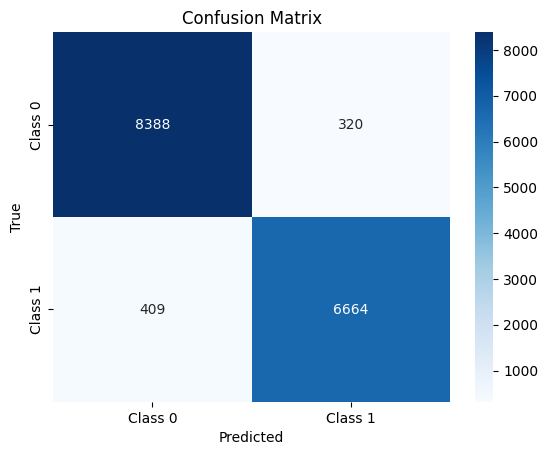

In [37]:
accuracy, y_true, y_pred = test_model(model, test_loader)

In [38]:
if accuracy > 0.9507:
    string = 'model-' + str(accuracy) + '.pth.'
    torch.save(model, string)
    print("Model został zapisany :)")

    # Dane do zapisania
    results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }
    
    filename = f"model-{str(accuracy)}-wyniki.pkl"
    
    # Zapis do pliku pickle
    with open(filename, 'wb') as file:
        pickle.dump(results, file)
    
    print("Wyniki zapisano do pliku :)")

Model został zapisany :)
Wyniki zapisano do pliku :)


# 6. Diagnostyka modelu 🛠️🔍

## Wizualizacja modelu 📊

In [39]:
print(classification_report(y_true, y_pred, target_names=["Real News", "Fake News"]))

              precision    recall  f1-score   support

   Real News       0.95      0.96      0.96      8708
   Fake News       0.95      0.94      0.95      7073

    accuracy                           0.95     15781
   macro avg       0.95      0.95      0.95     15781
weighted avg       0.95      0.95      0.95     15781



Wyniki klasyfikacji wskazują, że model działa równie skutecznie zarówno dla prawdziwych, jak i fałszywych wiadomości, osiągając precision, recall i f1-score w okolicach 95%.

Dokładność modelu wynosi 95%, co świadczy o jego wysokiej precyzji w identyfikowaniu obu klas.

Średnie wyniki makro i ważone potwierdzają stabilność modelu w równoważeniu obu kategorii, niezależnie od ich wielkości.

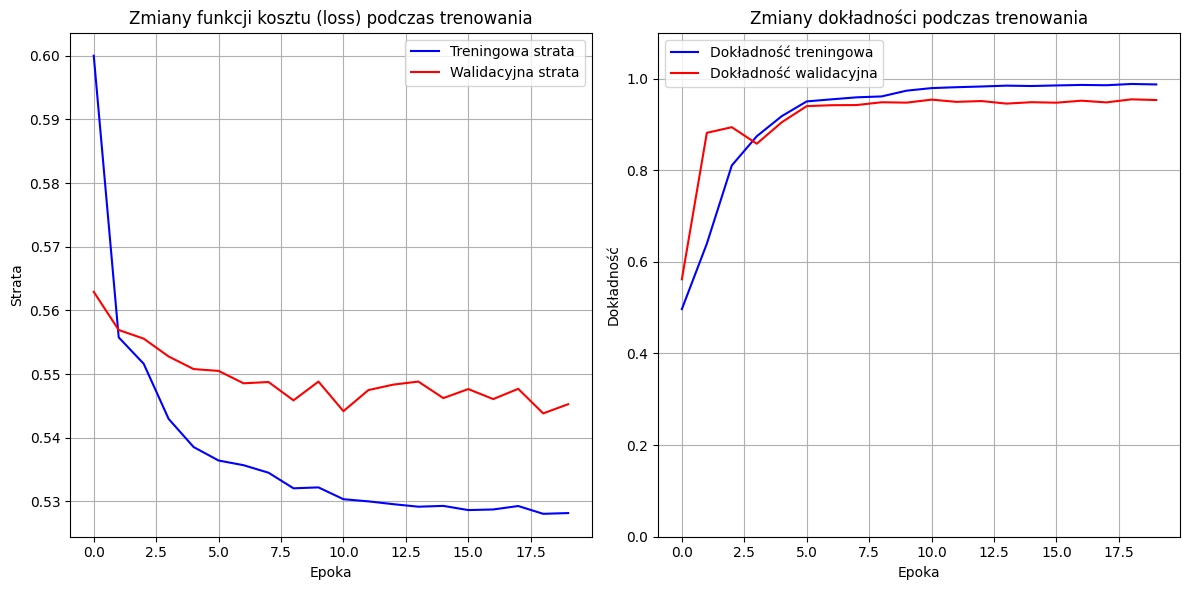

In [40]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Treningowa strata', color='blue')
plt.plot(val_losses, label='Walidacyjna strata', color='red')
plt.title('Zmiany funkcji kosztu (loss) podczas trenowania')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Dokładność treningowa', color='blue')
plt.plot(val_accuracies, label='Dokładność walidacyjna', color='red')
plt.ylim(0,1.1)
plt.title('Zmiany dokładności podczas trenowania')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Analiza błędów 🔍❌

In [43]:
test_data['predictions'] = y_pred
test_data['is_correct'] = (test_data['label'] == test_data['predictions'])

errors = test_data[test_data['is_correct'] == False]
false_positive = errors[(errors['label'] == 0) & (errors['predictions'] == 1)].iloc[0]
false_negative = errors[(errors['label'] == 1) & (errors['predictions'] == 0)].iloc[0]

print("Przykład False Positive (0 -> 1):")
print(f"Title: {false_positive['title']}\nLink: https://www.vox.com/policy-and-politics/2016/10/12/13228828/donald-trump-ground-game-expert-damage")

print("\nPrzykład False Negative (1 -> 0):")
print(f"Title: {false_negative['title']}\nLink: https://www.huffpost.com/entry/tom-hayden-courageous-warrior-for-peace_b_58117440e4b09b190529c081")

Przykład False Positive (0 -> 1):
Title: Trump’s campaign wants to salvage his ground game. But an expert says "the damage is done."
Link: https://www.vox.com/policy-and-politics/2016/10/12/13228828/donald-trump-ground-game-expert-damage

Przykład False Negative (1 -> 0):
Title: Tom Hayden, Courageous Warrior for Peace
Link: https://www.huffpost.com/entry/tom-hayden-courageous-warrior-for-peace_b_58117440e4b09b190529c081


In [42]:
false_positive = errors[(errors['label'] == 0) & (errors['predictions'] == 1)]
false_negative = errors[(errors['label'] == 1) & (errors['predictions'] == 0)]

token_to_word = {v: k for k, v in vocab.items()}

def tokens_to_words(tokens):
    return [token_to_word.get(token, '<UNK>') for token in tokens if len(token_to_word.get(token, '<UNK>')) >= 5]

fp_words = [word for tokens in false_positive['tokens'] for word in tokens_to_words(tokens)]
fn_words = [word for tokens in false_negative['tokens'] for word in tokens_to_words(tokens)]

fp_counter = Counter(fp_words)
fn_counter = Counter(fn_words)

print("Top 10 false positive words:")
for word, count in fp_counter.most_common(10):
    print(f"{word}: {count}")

print("\nTop 10 false negative words:")
for word, count in fn_counter.most_common(10):
    print(f"{word}: {count}")

Top 10 false positive words:
trump: 870
about: 811
their: 679
would: 588
clinton: 587
people: 540
which: 449
after: 380
president: 380
there: 371

Top 10 false negative words:
trump: 812
their: 678
about: 550
would: 439
people: 434
which: 418
after: 348
clinton: 343
other: 324
there: 320


## Porównanie modelu 🆚🤖

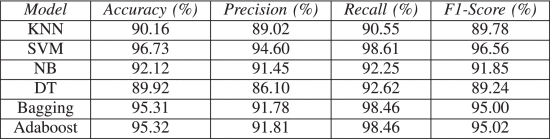

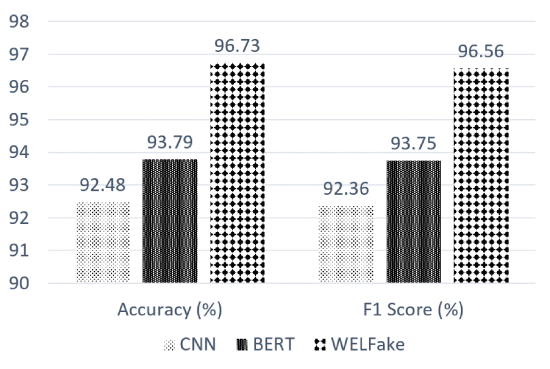


| Miejsce | Model      | Dokładność | F1-Score |
|---------|------------|------------|----------|
| 1 | SVM          | 96.73%      | 96.56% |
| **2** | **LSMT**     | **95.38%**      | **95.00%** |
| 3 | Adaboost     | 95.32%      | 95.02% |
| 4 | Bagging      | 95.31%      | 95.00% |
| 5 | Bert         | 93.79%      | 93.75% |
| 6 | CNN          | 92.48%      | 92.36% |
| 7 | NB           | 92.12%      | 91.85% |
| 8 | KNN          | 90.16%      | 89.78% |
| 9 | DT           | 89.92%      | 89.24% |

# 7. Podsumowanie 📝

Model LSTM skutecznie rozwiązał postawiony problem, osiągając dokładność 95.38%, co plasuje go na świetnym 2. miejscu w porównaniu z innymi podejściami. Taki wynik dowodzi efektywności zastosowanego modelu w wykrywaniu fałszywych wiadomości. Projekt jest przykładem udanego zastosowania sieci neuronowych w analizie tekstu oraz rozwiązywaniu problemów związanych z dezinformacją w Internecie.

Kluczowe w tym projekcie były odpowiednio dobrane hiperparametry, które miały znaczący wpływ na jakość klasyfikacji oraz struktura modelu, która skutecznie wykorzystuje dwukierunkowe LSTM do uchwycenia pełniejszego kontekstu w analizowanych tekstach. Dzięki tym elementom model osiągnął bardzo dobre wyniki w wykrywaniu fałszywych wiadomości. Poniżej przedstawiamy tabelę z wartościami najważniejszych hiperparametrów zastosowanych w projekcie.

| Hiperparametr              | Wartość      |
|-----------------------|--------------|
| **embedding_dim**      | 100          |
| **hidden_dim**         | 12           |
| **dropout_rate**       | 0.3          |
| **learning_rate**      | 0.001        |
| **epochs**             | 20            |
